In [1]:
import pandas as pd
import numpy as np
from environment import Environment
from pandas.tseries.offsets import MonthEnd
import instrument
from portfolio import Portfolio
from risk_parity import RiskParity
from copy import copy, deepcopy

%load_ext autoreload
%autoreload 2

In [2]:
from historical import HistoricalData
from pandas._libs.tslibs.timestamps import Timestamp, Timedelta

path = "data\\"
env_df = pd.read_csv(path + "Consolidated.csv", header = [0,1], index_col=[0])
targets_df = pd.read_csv(path + "Targets.csv", index_col=[0])
features_df = pd.read_csv(path + "Features.csv", header = [0,1], index_col=[0])
exps = pd.read_csv('data\\ETF_info.csv', index_col=0).loc[env_df[['EQ', 'EM', 'RE', 'FI']].columns.droplevel(), 'Expense Ratio'].astype(float)
data = HistoricalData(env_df, features_df, targets_df)

date = Timestamp('2014-03-01') + MonthEnd(0)
date_end = date + MonthEnd(62)
env_now = Environment(*data.get_env_args(date))
rp = RiskParity(data)


### Initializing stuff

In [3]:
usd = 200000/env_now.fx['CAD']
w_dict = rp.get_weights_ac(date, asset_classes=np.array(['FI', 'RE', 'EM']))
pos_dict = Portfolio.weights_to_pos(w_dict, env_now, usd)
pos_dict = Portfolio.etf_dict_from_names(pos_dict)
icash = instrument.Cash('USD')
pos_dict[icash] = 0

In [4]:
my_pf = Portfolio(pos_dict)
etf_w = 0.98
etf_total_val= my_pf.calc_value(env_now)*etf_w
opt_total_val = my_pf.calc_value(env_now)*(1-etf_w)

my_pf.rebalance(env_now, Portfolio.weights_to_pos(w_dict, env_now, etf_total_val), exps, time_past=0)


C = 1 + 0.02
K1 = C - 0.03
K2 = C
K3 = C + 0.03
ttm=2

specs = [{'name':'SPY Call 1', 'ccy':'USD', 'is_call':1, 'ul':'SPY US Equity'},
         {'name':'SPY Call 2', 'ccy':'USD', 'is_call':1, 'ul':'SPY US Equity'},
         {'name':'SPY Call 3', 'ccy':'USD', 'is_call':1, 'ul':'SPY US Equity'}
         ]

cost = Portfolio.get_opt_strategy_price(env_now, specs, [1, -2, 1], [K1,K2,K3], ttm=ttm)
nopt = opt_total_val/cost
ofee = my_pf.buy_options(env_now, specs, [nopt, -nopt*2, nopt], [K1,K2,K3], ttm=ttm)

last_pf_val = my_pf.calc_value(env_now)
last_etf_val = my_pf.get_eq_value(env_now)

last_eq_val = my_pf.get_names_value(env_now, env_df['EQ'].columns)
last_fi_val = my_pf.get_names_value(env_now, env_df['FI'].columns)
last_re_val = my_pf.get_names_value(env_now, env_df['RE'].columns)
last_em_val = my_pf.get_names_value(env_now, env_df['EM'].columns)

last_opt_val = my_pf.get_options_value(env_now)



### Set up performance df

In [5]:
perf_df = pd.DataFrame(index = pd.date_range(start=date, end=date_end, freq='M'))
perf_df['USD Value'] = 0
perf_df['CAD Value'] = 0
perf_df['PNL'] = 0
perf_df['Post-fee PNL'] = np.nan
perf_df['ETF PNL'] = np.nan

perf_df['EQ PNL'] = np.nan
perf_df['FI PNL'] = np.nan
perf_df['EM PNL'] = np.nan
perf_df['RE PNL'] = np.nan

perf_df['Option PNL'] = np.nan
perf_df['Delta PNL'] = np.nan
perf_df['Vega PNL'] = np.nan
perf_df['Theta PNL'] = np.nan
perf_df['Rho PNL'] = np.nan
perf_df['Unexplained PNL'] = np.nan

perf_df['Return'] = 0
perf_df['Post-fee Return'] = np.nan
perf_df['ETF Return'] = np.nan

perf_df['EQ Return'] = np.nan
perf_df['FI Return'] = np.nan
perf_df['EM Return'] = np.nan
perf_df['RE Return'] = np.nan

perf_df['Option Return'] = np.nan
perf_df['Delta Return'] = np.nan
perf_df['Vega Return'] = np.nan
perf_df['Theta Return'] = np.nan
perf_df['Rho Return'] = np.nan
perf_df['Unexplained Return'] = np.nan

perf_df['Injection'] = 0
perf_df['FX'] = env_now.fx['CAD']
perf_df['Option Fees'] = ofee
perf_df['ETF Fees'] = 0
perf_df['ETF Expenses'] = 0

perf_df['Total Fees'] = 0
perf_df['Percentage Fees'] = 0



### Run sim/backtest

In [6]:
perf_df.loc[date, 'USD Value'] = my_pf.calc_value(env_now)
perf_df.loc[date, 'CAD Value'] = my_pf.calc_value(env_now, ccy='CAD')
perf_df.loc[date, 'Return'] = np.nan
perf_df.loc[date, 'PNL'] = np.nan

while date < date_end:
    
    date = date + MonthEnd(1)
    env_before = deepcopy(env_now)
    env_now = Environment(*data.get_env_args(date))
    
    #if env_now.surfaces['SPY US Equity'].matrix[1,5] > 0.20:
    #    # print(date, ": high vol of {:.2f}".format(env_now.surfaces['SPY US Equity'].matrix[1,5]))
    #    etf_w = 1
    #else:
    #    etf_w = 0.98
    
    new_pf_val = my_pf.calc_value(env_now)
    new_etf_val = my_pf.get_eq_value(env_now)
    new_opt_val = my_pf.get_options_value(env_now)
    new_eq_val = my_pf.get_names_value(env_now, env_df['EQ'].columns)
    new_fi_val = my_pf.get_names_value(env_now, env_df['FI'].columns)
    new_re_val = my_pf.get_names_value(env_now, env_df['RE'].columns)
    new_em_val = my_pf.get_names_value(env_now, env_df['EM'].columns)
    
    w_dict = rp.get_weights_ac(date, asset_classes=np.array(['FI', 'RE', 'EM']))
    
    
    etf_total_val= my_pf.calc_value(env_now)*etf_w
    opt_total_val = my_pf.calc_value(env_now)*(1-etf_w)
    

    perf_df.loc[date, 'FX'] = env_now.fx['CAD']
    
    if (date.month == 8) or (date.month == 2):
        my_pf.pf_units[my_pf.get_cash('USD')] += 20000/env_now.fx['CAD']
        perf_df.loc[date, 'Injection'] = 20000/env_now.fx['CAD']
        
    
    
    perf_df.loc[date, 'PNL'] = new_pf_val - last_pf_val
    perf_df.loc[date, 'ETF PNL'] = new_etf_val - last_etf_val
    perf_df.loc[date, 'Option PNL'] = new_opt_val - last_opt_val
    
    attribs = my_pf.get_pnl_attr(env_before, env_now)
    perf_df.loc[date, 'Delta PNL'] = attribs['delta']
    perf_df.loc[date, 'Vega PNL'] = attribs['vega']
    perf_df.loc[date, 'Theta PNL'] = attribs['theta']
    perf_df.loc[date, 'Rho PNL'] = attribs['rho']
    perf_df.loc[date, 'Unexplained PNL'] = perf_df.loc[date, 'Option PNL'] -\
            attribs['delta'] - attribs['vega'] - attribs['theta'] - attribs['rho']
    
    perf_df.loc[date, 'EQ PNL'] = new_eq_val - last_eq_val
    perf_df.loc[date, 'FI PNL'] = new_fi_val - last_fi_val
    perf_df.loc[date, 'EM PNL'] = new_em_val - last_em_val
    perf_df.loc[date, 'RE PNL'] = new_re_val - last_re_val
    
    perf_df.loc[date, 'Return'] = (new_pf_val - last_pf_val)/last_pf_val
    perf_df.loc[date, 'ETF Return'] = (new_etf_val - last_etf_val)/last_pf_val
    perf_df.loc[date, 'Option Return'] = (new_opt_val - last_opt_val)/last_pf_val
    perf_df.loc[date, 'Delta Return'] = attribs['delta']/last_pf_val
    perf_df.loc[date, 'Vega Return'] = attribs['vega']/last_pf_val
    perf_df.loc[date, 'Theta Return'] = attribs['theta']/last_pf_val
    perf_df.loc[date, 'Rho Return'] = attribs['rho']/last_pf_val
    perf_df.loc[date, 'Unexplained Return'] = perf_df.loc[date, 'Unexplained PNL']/last_pf_val
    
    perf_df.loc[date, 'EQ Return'] = (new_eq_val - last_eq_val)/last_pf_val
    perf_df.loc[date, 'FI Return'] = (new_fi_val - last_fi_val)/last_pf_val
    perf_df.loc[date, 'EM Return'] = (new_em_val - last_em_val)/last_pf_val
    perf_df.loc[date, 'RE Return'] = (new_re_val - last_re_val)/last_pf_val
    
    
    efee, eexps = my_pf.rebalance(env_now, Portfolio.weights_to_pos(w_dict, env_now, etf_total_val), exps)
    ofee = my_pf.sell_options(env_now)
    
    # re-buy options
    
    cost = Portfolio.get_opt_strategy_price(env_now, specs, [1, -2, 1], [K1,K2,K3], ttm=ttm)
    nopt = opt_total_val/cost    
    ofee += my_pf.buy_options(env_now, specs, [nopt, -nopt*2, nopt], [K1,K2,K3], ttm=ttm)
    
    # record post-rebalancing (next month starting) portf value
    perf_df.loc[date, 'USD Value'] = my_pf.calc_value(env_now)
    perf_df.loc[date, 'CAD Value'] = my_pf.calc_value(env_now, ccy='CAD')
    perf_df.loc[date, 'Post-fee Return'] = (perf_df.loc[date, 'USD Value'] - perf_df.loc[date, 'Injection'])/perf_df.loc[date + MonthEnd(-1), 'USD Value'] - 1
    perf_df.loc[date, 'Post-fee PNL'] = (perf_df.loc[date, 'USD Value'] - perf_df.loc[date, 'Injection']) - perf_df.loc[date + MonthEnd(-1), 'USD Value']
    
    # record fees
    perf_df.loc[date, 'ETF Fees'] = efee
    perf_df.loc[date, 'ETF Expenses'] = eexps
    perf_df.loc[date, 'Option Fees'] = ofee
    perf_df.loc[date, 'Total Fees'] = ofee + eexps + efee
    perf_df.loc[date, 'Percentage Fees'] = (ofee + eexps + efee)/last_pf_val
    
    # find post fee returns
    
    
    # record post rebalancing values for opts and eqs
    last_pf_val = my_pf.calc_value(env_now)
    last_etf_val = my_pf.get_eq_value(env_now)
    last_opt_val = my_pf.get_options_value(env_now)
    last_eq_val = my_pf.get_names_value(env_now, env_df['EQ'].columns)
    last_fi_val = my_pf.get_names_value(env_now, env_df['FI'].columns)
    last_re_val = my_pf.get_names_value(env_now, env_df['RE'].columns)
    last_em_val = my_pf.get_names_value(env_now, env_df['EM'].columns)
    
    #####
    # my_pf.get_forw_risk(env_now: Environment, dist: Distribution, N=1000) vector of 1000 simulated forward pnls
    # -> self.emp_dist = xxxx
    # -> my_pf.calc_var()
    # -->   return -np.percentile(self.emp_dist, 5)
    # -> my_pf.calc_cvar()
    
    
    #####
    

In [7]:
my_pf.get_options()[0].get_greeks(env_now)

{'delta': 0.5752521451668763,
 'gamma': 0.01573381241576674,
 'vega': 59.586495541189265,
 'theta': -29.51746307746316,
 'rho': 33.92496903814483}

In [8]:
sub_df = perf_df[['Option PNL', 'Delta PNL', 'Vega PNL', 'Theta PNL', 'Rho PNL', 'Unexplained PNL']]
sub_df.loc[sub_df.index, 'UL'] = env_df['EQ'].loc[sub_df.index, 'SPY US Equity']
sub_df

C:\Users\Sunny\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Sunny\Anaconda3\lib\site-packages\pandas\core\indexing.py:366: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(new_indexer, value)
C:\Users\Sunny\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versu

,Option PNL,Delta PNL,Vega PNL,Theta PNL,Rho PNL,Unexplained PNL,UL
2014-03-31,NaN,NaN,NaN,NaN,NaN,NaN,229.8109
2014-04-30,2411.700062,435.435999,201.389970,859.942420,0.000000,914.931673,231.4084
2014-05-31,6411.938944,1467.345743,1815.578847,874.114600,1.056344,2253.843411,236.7786
2014-06-30,5880.344984,1417.710158,1546.075519,825.163486,-1.158988,2092.554809,241.6641
2014-07-31,-1190.663813,-1202.724721,-1576.899623,822.835270,0.000000,766.125261,238.4168
2014-08-31,8574.578462,2238.185149,4688.752402,993.313589,0.000000,654.327321,247.8255
2014-09-30,-1328.084641,-1218.369118,-1726.901403,967.892745,0.000000,649.293135,244.4077
2014-10-31,8014.343293,1765.349019,3030.544205,1181.637223,0.000000,2036.812845,250.1637
2014-11-30,8864.241609,1982.259665,4078.400607,1156.551407,3.649996,1643.379934,257.0362
2014-12-31,-215.518379,-216.844776,-1652.706407,1017.592233,-1.348717,637.789289,256.3782


### Evaluate performance

In [9]:
irr_values = np.array([-perf_df['USD Value'].iloc[0]] + (-perf_df['Injection'].values).tolist())
irr_values[-1] += perf_df['USD Value'].iloc[-1]
np.irr(irr_values)*12

0.21433130744893703

In [10]:
ret_vec =  perf_df['Return'].dropna().values
# ret_vec = perf_df['Option Return'].dropna().values


m = ret_vec.mean()*12
s = ret_vec.std()*np.sqrt(12)
var = -np.percentile(ret_vec, 5)*np.sqrt(12)
cvar = -ret_vec[ret_vec<np.percentile(ret_vec, 5)].mean()*np.sqrt(12)
print("Mean: {:.1f}%\nStd: {:.1f}%\nVaR: {:.1f}%\nCVaR: {:.1f}%".format(m*100, s*100, var*100, cvar*100))
print("Sharpe: {:.1f}".format(m/s))

Mean: 24.0%
Std: 9.3%
VaR: 9.8%
CVaR: 11.5%
Sharpe: 2.6


In [11]:
import matplotlib.pyplot as plt
perf_df['Return'].dropna().hist()
plt.show()

<Figure size 640x480 with 1 Axes>

In [12]:
print(perf_df['ETF Return'].std()*np.sqrt(12))
print(perf_df['ETF Return'].mean()*12)

0.05582663959917873
0.04925372730853804


In [13]:
print(perf_df['Option Return'].std()*np.sqrt(12))
print(perf_df['Option Return'].mean()*12)

0.06750938142639772
0.19084999326513125


In [14]:
my_pf.get_forward_pnl(env_now, data, 10000)

### Risk stuff for current portfolio

In [87]:
#display these numbers somewhere in the report

var_loss = my_pf.calc_var()/my_pf.calc_value(env_now)*100
cvar_loss = my_pf.calc_es()/my_pf.calc_value(env_now)*100
print("Est. VaR loss: {:.2f}%".format(var_loss))
print("Est. CVaR loss: {:.2f}%".format(cvar_loss))

std = np.std(my_pf.emp_dist)/my_pf.calc_value(env_now)*100
print("Est. Standard Deviation: {:.2f}%".format(std))

Est. VaR loss: 3.74%
Est. CVaR loss: 4.74%
Est. Standard Deviation: 2.90%


In [84]:
#these are percentage risk contributions without options
(my_pf.calc_risk_contribs(env_now)/my_pf.calc_risk_contribs(env_now).sum())*100

,Component VaR
SPY US Equity,0.000000
EFA US Equity,0.000000
XLF US Equity,0.000000
XLK US Equity,0.000000
XLV US Equity,0.000000
XLP US Equity,0.000000
XLE US Equity,0.000000
EWJ US Equity,0.000000
XLU US Equity,0.000000
XLI US Equity,0.000000


(array([  18.,  200.,  896., 1940., 2602., 2303., 1425.,  519.,   90.,
           7.]),
 array([-72201.02599335, -55303.16543167, -38405.30486999, -21507.44430832,
         -4609.58374664,  12288.27681504,  29186.13737671,  46083.99793839,
         62981.85850007,  79879.71906174,  96777.57962342]),
 <a list of 10 Patch objects>)

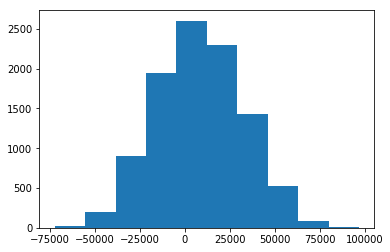

In [17]:
#you can copy my_pf.emp_dist to excel and create a histogram there
# ie my_pf.emp_dist
plt.hist(my_pf.emp_dist)

In [93]:
#backtested VaR shows reasonable results
-(perf_df['Return']).sort_values()[0:5]*100

2018-02-28    3.524619
2015-08-31    3.473311
2014-09-30    3.435959
2018-10-31    2.863944
2015-06-30    2.196193
Name: Return, dtype: float64

In [19]:
greeks = my_pf.calc_opt_greeks(env_now)

In [20]:
#potential(expected) PnL given a reasonable movement
print(greeks['delta']*env_now.prices['SPY US Equity']*0.01)
#we expect 1% movement in SPY over 1 month
print(0.5*greeks['gamma']*(env_now.prices['SPY US Equity']*0.01)**2)
print(greeks['vega']*0.01)
#we might expect a 1% move in vega
print(greeks['theta']/12)
# literally from 1 month of theta

1708.765890947096
-89.64282191255886
-776.6528670115815
4030.617481308407


In [39]:
#scenario analysis 
from historical import Distribution, ShockMap


dist = Distribution(data, date, method = "Normal")
sm = ShockMap(data, date)
curr_port_value = my_pf.calc_value(env_now)
#print(curr_port_value)
pnl = []

#GDP down 1% monthly
sim_fact_shock = dist.generate_cond_shock_cf('GDP Change', condition = -0.01)
sim_shock = sm.map_factors(sim_fact_shock)
sim_env = env_now.simulate(sim_shock)
#print(my_pf.calc_value(sim_env) - curr_port_value)
pnl.append(my_pf.calc_value(sim_env) - curr_port_value)

#Volatility up 50% 
sim_fact_shock = dist.generate_cond_shock_cf('IVMID Change', condition = 0.50)
sim_shock = sm.map_factors(sim_fact_shock)
sim_env = env_now.simulate(sim_shock)
#print(my_pf.calc_value(sim_env) - curr_port_value)
pnl.append(my_pf.calc_value(sim_env) - curr_port_value)

#Volatility down 50%
sim_fact_shock = dist.generate_cond_shock_cf('IVMID Change', condition = -0.50)
sim_shock = sm.map_factors(sim_fact_shock)
sim_env = env_now.simulate(sim_shock)
#print(my_pf.calc_value(sim_env) - curr_port_value)
pnl.append(my_pf.calc_value(sim_env) - curr_port_value)

#SPY down 5%
sim_fact_shock = dist.generate_cond_shock_cf('SPY Change', condition = -0.05)
sim_shock = sm.map_factors(sim_fact_shock)
sim_env = env_now.simulate(sim_shock)
#print(my_pf.calc_value(sim_env) - curr_port_value)
pnl.append(my_pf.calc_value(sim_env) - curr_port_value)

#SPY up 5%
sim_fact_shock = dist.generate_cond_shock_cf('SPY Change', condition = 0.05)
sim_shock = sm.map_factors(sim_fact_shock)
sim_env = env_now.simulate(sim_shock)
#print(my_pf.calc_value(sim_env) - curr_port_value)
pnl.append(my_pf.calc_value(sim_env) - curr_port_value)

#10Y IR up 1%
sim_fact_shock = dist.generate_cond_shock_cf('T10Y Change', condition = 0.01)
sim_shock = sm.map_factors(sim_fact_shock)
sim_env = env_now.simulate(sim_shock)
#print(my_pf.calc_value(sim_env) - curr_port_value)
pnl.append(my_pf.calc_value(sim_env) - curr_port_value)

my_pf.calc_value(env_now)


833737.9128092142
7905.853497927892
-19414.532251734287
3417.5833456120454
-14458.878962670336
41378.37266502704
-3176.433381762821


833737.9128092142

In [55]:
Scenarios = ['GDP down 1%','Volatility Up 50%', 'Volatility Down 50%', 'SPY Down 5%', 'SPY Up 5%', '10Y IR Up 1%']
pnl

s_anal = pd.DataFrame(pnl, index = Scenarios, columns = ['PnL'])
s_anal['Percentage Change in Portfolio Value'] = (s_anal['PnL']/curr_port_value) * 100
s_anal


,PnL,Percentage Change in Portfolio Value
GDP down 1%,7905.853498,0.948242
Volatility Up 50%,-19414.532252,-2.328613
Volatility Down 50%,3417.583346,0.409911
SPY Down 5%,-14458.878963,-1.734224
SPY Up 5%,41378.372665,4.962995
10Y IR Up 1%,-3176.433382,-0.380987


In [103]:
#current portfolio ETF exposure values
my_pf.calc_value(env_now)
exposure = list(my_pf.pf_dollars.values())
names = []
for instru in list(my_pf.pf_dollars.keys()):
    names.append(instru.name)

exp_by_instru = pd.Series(exposure, index = names)
exp_by_instru


TIP US Equity       99589.112480
AGG US Equity       99589.112480
IEF US Equity       99589.112480
TLT US Equity       99589.112480
SHY US Equity       99589.112480
LQD US Equity       99589.112480
IYR US Equity       37729.225035
RWR US Equity       37729.225035
ICF US Equity       37729.225035
EWZ US Equity       35778.068236
ISMUF US Equity     35778.068236
ILF US Equity       35778.068236
SPY US Equity           0.000000
EFA US Equity           0.000000
XLF US Equity           0.000000
XLK US Equity           0.000000
XLV US Equity           0.000000
XLP US Equity           0.000000
XLE US Equity           0.000000
EWJ US Equity           0.000000
XLU US Equity           0.000000
XLI US Equity           0.000000
EZU US Equity           0.000000
XLB US Equity           0.000000
IXN US Equity           0.000000
IYZ US Equity           0.000000
IEV US Equity           0.000000
NaN                  -569.874642
SPY Call 1         132224.831102
SPY Call 2        -172885.956718
SPY Call 3

In [104]:
# this is the equivalent dollar delta exposure of options. 
my_pf.calc_opt_greeks(env_now)['delta']*env_now.prices['SPY US Equity']


170876.5890947096

In [106]:
w_dict

{'TIP US Equity': 0.1217386645319019,
 'AGG US Equity': 0.1217386645319019,
 'IEF US Equity': 0.1217386645319019,
 'TLT US Equity': 0.1217386645319019,
 'SHY US Equity': 0.1217386645319019,
 'LQD US Equity': 0.1217386645319019,
 'IYR US Equity': 0.04612055831478875,
 'RWR US Equity': 0.04612055831478875,
 'ICF US Equity': 0.04612055831478875,
 'EWZ US Equity': 0.0437354459547408,
 'ISMUF US Equity': 0.0437354459547408,
 'ILF US Equity': 0.0437354459547408,
 'SPY US Equity': 0,
 'EFA US Equity': 0,
 'XLF US Equity': 0,
 'XLK US Equity': 0,
 'XLV US Equity': 0,
 'XLP US Equity': 0,
 'XLE US Equity': 0,
 'EWJ US Equity': 0,
 'XLU US Equity': 0,
 'XLI US Equity': 0,
 'EZU US Equity': 0,
 'XLB US Equity': 0,
 'IXN US Equity': 0,
 'IYZ US Equity': 0,
 'IEV US Equity': 0}